# Menu <a class="anchor" id="menu"></a>
   
* [1. Introduction au Topic Modelling](#introduction)
* [2. Analyses Exploratoires des jeux de données](#EDA)
    * [2.1 yelp_academic_dataset_**business**.json](#EDA_business)
    * [2.2 yelp_academic_dataset_**review**.json](#EDA_reviews)
    * [2.3 Préparation du jeu de données de travail](#data_work)
    * [2.4 Analyses du nouveau jeu de données](#multivariate_analysis)
* [3. Prétraitement des données](#pretraitement)
    * [3.1 Tokenization](#tokenize)
    * [3.2 Filtrage des tokens](#filter)
    * [3.3 Lemmatization des tokens](#lemmatize)
    * [3.4 Suppression des mots les plus fréquents](#most_frequents)
    * [3.5 Création du Dictionnaire](#dict)
    * [3.6 Création du Corpus Bag-Of-Words](#corpus_bow)
    * [3.7 Création du Curpus TF-IDF](#corpus_tfidf)
* [4. Topic Modelling avec LDA](#lda_topic_modelling)
    * [4.1 Latent Dirichlet Allocation *(LDA)*](#lda)
    * [4.2 Recheche du nombre de sujets avec le score de cohérence](#lda_coherence)
    * [4.3 Log des courbes de cohérences pour divers essais](#lda_coherence_logs)
* [5. Topic Modelling avec NMF](#nmf_topic_modelling)
    * [5.1 Negative Matrix Factorisation *(NMF)*](#nmf)
    * [5.2 Recheche du nombre de sujets avec le score de cohérence](#nmf_coherence)
    * [5.3 Log des courbes de cohérences pour divers essais](#nmf_coherence_logs)
* [6. Choix et entrainement du modèle final](#final_model)
    * [6.1 Entrainement & interprétation du meilleur modèle LDA](#final_model_lda)
    * [6.2 Entrainement & interprétation du meilleur modèle NMF](#final_model_nmf)
    * [6.3 Export du modèle sélectionné](#final_model_export)

---
---
# 1. Introduction au Topic Modelling <a class="anchor" id="introduction"></a> [⇪](#menu)

Un algorithme de topic modelling est un modèle mathématique/statistique utilisé pour déduire quels sont les sujets qui représentent le mieux les données.

Il est basée sur les hypothèses suivantes :
- Un texte (document) est composé de plusieurs sujets.
- Un sujet est composé d'une collection de mots

Le but de l'algorithme est de calculer une *note* de participation à un thème donné pour chaque mot d'un texte, et pour y parvenr nous allons suivre les étapes ci-dessous:

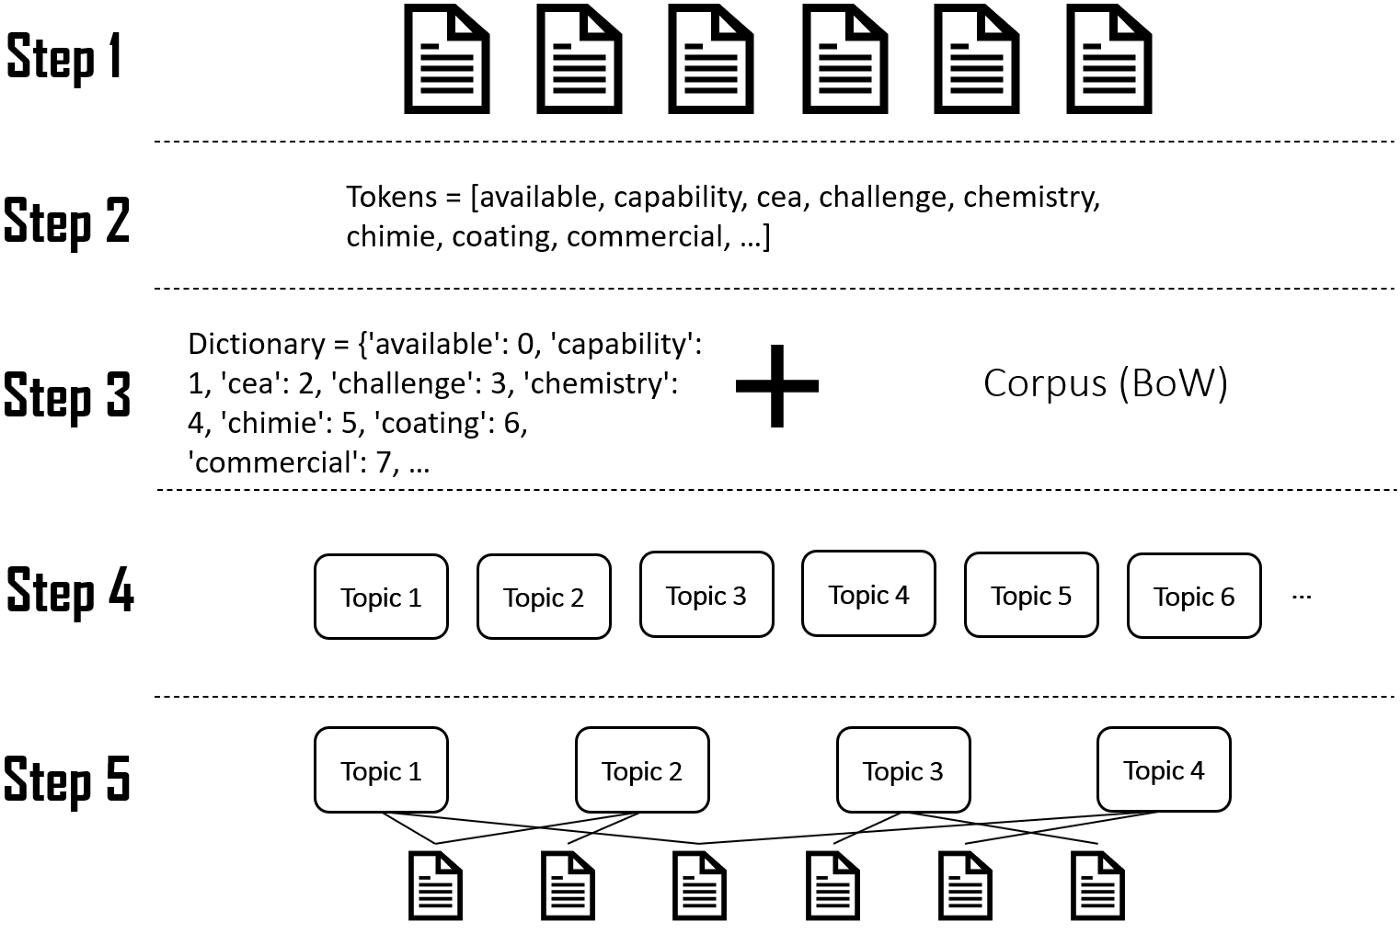

- **Step1** : consiste à *récupèrer les données* et à *conduire une Analyse Exploratoire des données*.
- **Step2** : consiste à *tokeniser* les textes *(c'est à dire découper les phrases mot à mot)*.
- **Step3** : consiste à *créer un dictionnaire associant chaque mot à un ID unique* puis à *créer un Bag Of Words* représentant la fréquence des tokens. 
- **Step4** : consiste à *construire un modèle permettant d'identifier les sujets* puis à l'ajuster *trouver le nombre optimal de sujets*.
- **Step5** : consiste à *utiliser le modèle crée* pour connaitre la distribution des sujets identifiés dans les *(potentiellement nouveaux)* documents.

In [1]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# import pyLDAvis
# import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
import spacy_fastlang
from collections import Counter
from pprint import pprint
from tqdm import tqdm
# from tqdm.notebook import tqdm

# import logging
# logging.captureWarnings(True)
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')
# warnings.filterwarnings("ignore", category=DeprecationWarning) 
# warnings.filterwarnings("ignore", message=".*the imp module is deprecated in favour of importlib;(.|\n)*") # supports regular expressions

random_seed = 0
np.random.seed(random_seed)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
def get_num_lines(path):
    with open(path) as f:
        for i, _ in enumerate(f):
            pass
    return i+1

In [3]:
def plot_bars(data_, title, labels_modulo=1, labels_rotation=90, show_values=True, show_percent=False, x_label=None, y_label=None, **args):
    
    if show_percent:
        total = data_.values.sum()
        data_ = round(data_/total*100.0,2)

    fig = plt.figure(figsize=(15, 4))
    
    ax = sns.barplot(data=data_, **args)
    
    if show_values:
        ax.bar_label(ax.containers[0])
        
    new_ticks = [i.get_text() for i in ax.get_xticklabels()]
    plt.xticks(range(0, len(new_ticks), labels_modulo), new_ticks[::labels_modulo], rotation=labels_rotation)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

---
---
# 2. Analyses Exploratoires <a class="anchor" id="EDA"></a> [⇪](#menu)

## 2.1 `yelp_academic_dataset_business.json` <a class="anchor" id="EDA_business"></a> [⇪](#menu)

In [4]:
file_path = os.path.join("data", "yelp_dataset", "yelp_academic_dataset_business.json")
data_business = pd.read_json(file_path, lines=True)  # 150346 x 14
display(data_business.head(2), data_business.shape)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."


(150346, 14)

In [5]:
data_business.categories.value_counts()

Beauty & Spas, Nail Salons                                                                                       1012
Restaurants, Pizza                                                                                                935
Nail Salons, Beauty & Spas                                                                                        934
Pizza, Restaurants                                                                                                823
Restaurants, Mexican                                                                                              728
                                                                                                                 ... 
Dermatologists, Health & Medical, Cosmetic Surgeons, Doctors, Acne Treatment, Skin Care, Beauty & Spas              1
Home Services, Home & Garden, Nurseries & Gardening, Hardware Stores, Shopping, Building Supplies, Appliances       1
Food Trucks, Smokehouse, Restaurants, Food, Barbeque, So

In [6]:
data_business.categories.str.contains('Restaurant').value_counts(dropna=False)

False    97957
True     52286
None       103
Name: categories, dtype: int64

>#### Il y a visiblement beaucoup de commerces qui ne sont pas des restaurants... on va donc devoir trouver un moyen d'isoler les reviews qui concernent les restaurants.

### Préparation d'un jeu de données regroupants les business qui sont des restaurants

In [7]:
data_restaurant = data_business[data_business.categories.str.contains("Restaurant") == True]
display(data_restaurant.head(2), data_restaurant.shape)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."


(52286, 14)

## 2.2 `yelp_academic_dataset_review.json` <a class="anchor" id="EDA_reviews"></a> [⇪](#menu)

In [8]:
file_path = os.path.join("data", "yelp_dataset", "yelp_academic_dataset_review.json")
data_review = pd.read_json(file_path, lines=True, nrows=1000000)  # 6990280 x 9
display(data_review.head(2), data_review.shape)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18


(1000000, 9)

In [9]:
(get_num_lines(file_path), data_review.shape[1])

(6990280, 9)

### Regardons plus en détails les variables du jeu de données

#### Les variables qualitatives

In [10]:
data_review.describe(exclude=['number','datetime']).T

,count,unique,top,freq
review_id,1000000,1000000,KU_O5udG6zpxOg-VcAEodg,1
user_id,1000000,542003,_BcWyKQL16ndpBdggh2kNA,483
business_id,1000000,27095,GBTPC53ZrG1ZBY3DT8Mbcw,4661
text,1000000,998357,I have eaten at just about every decent Indian...,5


#### Les variables quantitatives

In [11]:
data_review.describe(datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max,std
stars,1000000.0,3.783959,1.0,3.0,4.0,5.0,5.0,1.440197
useful,1000000.0,1.106594,0.0,0.0,0.0,1.0,539.0,2.848906
funny,1000000.0,0.307812,0.0,0.0,0.0,0.0,284.0,1.428185
cool,1000000.0,0.457129,0.0,0.0,0.0,0.0,172.0,1.799114
date,1000000,2016-07-13 10:09:02.464016128,2005-03-01 17:47:15,2014-08-07 16:29:16.500000,2016-10-11 16:02:42,2018-09-01 01:26:22.249999872,2022-01-19 19:47:59,NaN


## 2.3 Préparation du jeu de données de travail <a class="anchor" id="data_work"></a> [⇪](#menu)

### Supprimons les reviews qui ne concernent pas des restaurants et gardons uniquement les colonnes utiles pour la suite

In [12]:
join_restaurant_reviews = data_review.merge(data_restaurant, on='business_id', how='left')

In [13]:
join_restaurant_reviews.categories.value_counts(dropna=False)

NaN                                                                                                                                   310481
Restaurants, Mexican                                                                                                                    7915
Mexican, Restaurants                                                                                                                    6219
Restaurants, Pizza                                                                                                                      4760
German, Restaurants, Seafood, Cocktail Bars, French, Brasseries, American (New), Nightlife, Bars, Cajun/Creole, Breakfast & Brunch      4661
                                                                                                                                       ...  
Pakistani, Restaurants                                                                                                                     1
Imported Food

In [14]:
data_review_restos = join_restaurant_reviews[['stars_x', 'text', 'user_id', 'business_id', 'review_id']][join_restaurant_reviews.categories.notnull()]
data_review_restos.rename(columns={'stars_x':'stars'}, inplace=True)
display(data_review_restos.head(2), data_review_restos.shape)

,stars,text,user_id,business_id,review_id
0,3,"If you decide to eat here, just be aware it is...",mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,KU_O5udG6zpxOg-VcAEodg
2,3,Family diner. Had the buffet. Eclectic assortm...,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,saUsX_uimxRlCVr67Z4Jig


(689519, 5)

### Supprimons les éventuels doublons

#### Vérifions tout d'abord si l'on a des doublons sur la base des colonnes que nous avons gardés

In [15]:
data_review_restos.duplicated().sum()

0

#### Mais il se pourrait que chaque review ait bien un ID unique alors que l'on a plusieurs fois les mêmes textes par un même client sur le même restaurant...

In [16]:
subset = ['stars', 'text', 'user_id', 'business_id']
data_review_restos.duplicated(subset=subset).sum()

1003

#### Comparons quelque uns de ces duplicatas pour vérifier...

In [17]:
data_review_restos[data_review_restos.duplicated(subset=subset, keep='first')].sort_values('text').head()

,stars,text,user_id,business_id,review_id
586767,5,"""Prep's Breakfast Sammie"" is the BEST breakfas...",Xf5hPJl9P4r9rRAy-NR46g,UCMSWPqzXjd7QHq7v8PJjQ,Oz8E7WQ5JVlrCC6-PGdY8Q
416542,2,"""We ran out of bread"" they said, as we drove o...",oUzXQqxXkFGL5k1OEmFr4g,34Eqv8jXgxg_EEwcsNgeeg,CF4rf7--EneYMVHAPgX7Jg
460249,1,"""Who's in the kitchen and why can't they do th...",CL5U0V87_Ord4cp9pE40Pw,XQfwVwDr-v0ZS3_CbbE5Xw,PnqDAlcL2-S9oOgn34Lzkw
202235,2,2 stars for cheap drinks. I was happy to see t...,ce9ZWyllsjOGHtdu6NpZww,4yKv0SEpuJDHECFinhifWQ,r_FsYzzKJG4wCgebF7e_sQ
684442,1,20 minutes and no server. Owner finally took a...,dTY6QRU-ox_HqX1A7I88tw,Ea2hPSFazxXITET4f6ZJhw,VNMwljSo3CGUwdiUQSukPg


In [18]:
data_review_restos[data_review_restos.duplicated(subset=subset, keep='last')].sort_values('text').head()

,stars,text,user_id,business_id,review_id
498137,5,"""Prep's Breakfast Sammie"" is the BEST breakfas...",Xf5hPJl9P4r9rRAy-NR46g,UCMSWPqzXjd7QHq7v8PJjQ,uZ0nZRQ-RpttoLCym2DyHw
322765,2,"""We ran out of bread"" they said, as we drove o...",oUzXQqxXkFGL5k1OEmFr4g,34Eqv8jXgxg_EEwcsNgeeg,mSKC9E97PpwdB3L3Jnxc2A
60045,1,"""Who's in the kitchen and why can't they do th...",CL5U0V87_Ord4cp9pE40Pw,XQfwVwDr-v0ZS3_CbbE5Xw,241ycTAVakh4sY8b7S_jyQ
134308,2,2 stars for cheap drinks. I was happy to see t...,ce9ZWyllsjOGHtdu6NpZww,4yKv0SEpuJDHECFinhifWQ,z2Cl4obOdxpC1uDnnsdnQw
371454,1,20 minutes and no server. Owner finally took a...,dTY6QRU-ox_HqX1A7I88tw,Ea2hPSFazxXITET4f6ZJhw,SdHOvSqwRRZHaX-ON8QEmw


#### On a effectivement quelques doublons qu'il vaudrait mieux nettoyer pour éviter de mettre plus de poids sur certains mots

In [19]:
print("AVANT:", data_review_restos.shape)
data_review_restos.drop_duplicates(subset=subset, inplace=True)
print("APRÈS:", data_review_restos.shape)

AVANT: (689519, 5)
APRÈS: (688516, 5)


#### Enfin supprimons les colonnes qui ne servaient qu'à vérifier la présence de doublons

In [20]:
data_review_restos = data_review_restos[['stars', 'text']]

## 2.4 Analyses du nouveau jeu de données <a class="anchor" id="multivariate_analysis"></a> [⇪](#menu)

#### Les variables qualitatives

In [21]:
data_review_restos.describe(exclude=['number','datetime']).T

,count,unique,top,freq
text,688516,688358,"At the height of the Omicron surge, Wendy's DO...",4


#### Les variables quantitatives

In [22]:
data_review_restos.describe(datetime_is_numeric=True).T

,count,mean,std,min,25%,50%,75%,max
stars,688516.0,3.801225,1.368445,1.0,3.0,4.0,5.0,5.0


### Répartition de la taille des reviews

In [23]:
data_tmp = data_review_restos.copy()
data_tmp['review_size'] = data_review_restos.text.apply(lambda x: len(x.split()))

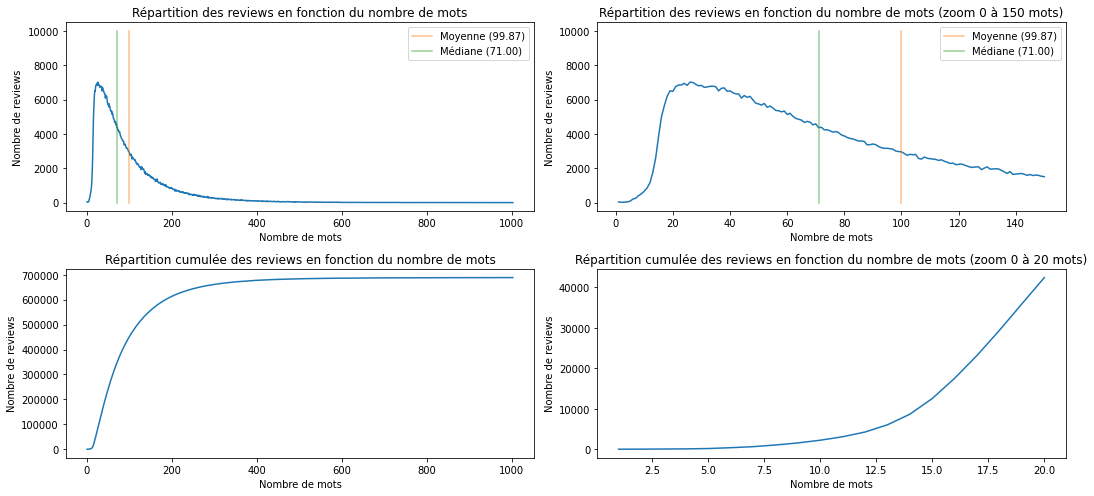

In [24]:
select = pd.DataFrame(data_tmp.review_size.value_counts()).reset_index()
select.sort_values(by='index', inplace=True)
select.set_index('index', inplace=True)

review_size_mean = data_tmp.review_size.mean()
review_size_median = data_tmp.review_size.median()

fig = plt.figure(figsize=(15, 7))
plt.subplot(2,2,1)
sns.lineplot(data=select, y='review_size', x='index')
plt.plot([review_size_mean,review_size_mean],[0,10000], label=f"Moyenne ({review_size_mean:.2f})", alpha=0.5)
plt.plot([review_size_median,review_size_median],[0,10000], label=f"Médiane ({review_size_median:.2f})", alpha=0.5)
plt.title("Répartition des reviews en fonction du nombre de mots")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de reviews")
#plt.ylim(0,10000)
plt.legend()

plt.subplot(2,2,2)
zoom_left, zoom_right = 0, 150
sns.lineplot(data=select[zoom_left:zoom_right], y='review_size', x='index')
plt.plot([review_size_mean,review_size_mean],[0,10000], label=f"Moyenne ({review_size_mean:.2f})", alpha=0.5)
plt.plot([review_size_median,review_size_median],[0,10000], label=f"Médiane ({review_size_median:.2f})", alpha=0.5)
plt.title(f"Répartition des reviews en fonction du nombre de mots (zoom {zoom_left} à {zoom_right} mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de reviews")
#plt.ylim(0,10000)
plt.legend()

select2 = np.cumsum(select)

plt.subplot(2,2,3)
sns.lineplot(data=select2, y='review_size', x='index')
#plt.plot([xxx,xxx],[0,10000], label="Moyenne", alpha=0.5)
plt.title("Répartition cumulée des reviews en fonction du nombre de mots")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de reviews")

plt.subplot(2,2,4)
zoom_left, zoom_right = 0, 20
sns.lineplot(data=select2[zoom_left:zoom_right], y='review_size', x='index')
plt.title(f"Répartition cumulée des reviews en fonction du nombre de mots (zoom {zoom_left} à {zoom_right} mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de reviews")

plt.tight_layout()
plt.show()

In [25]:
data_tmp.review_size.describe()

count    688516.000000
mean         99.865116
std          92.380733
min           1.000000
25%          40.000000
50%          71.000000
75%         128.000000
max        1003.000000
Name: review_size, dtype: float64

In [26]:
data_tmp[ data_tmp.review_size > 457 ].shape

(6855, 3)

>#### On constate que :
> - la moitié des reviews ont moins de 75 "mots"
> - 48 des 1.000.000 de reviews ont 1 "mot"...
> - 275 des 1.000.000 de reviews ont 5 "mots" ou moins.
> - environ 800.000 des 1.000.000 de reviews ont moins de 150 "mots"

---
>#### `TODO`  done ✅ | todo ❌ |

> - ✅ Il faut supprimer les outliers. Ils risquent d'utiliser des mots non réprésentatifs.
<br><u>*(action: fait ci-dessous)*</u>

#### Supprimons les outliers avec trop de textes et qui risquent donc d'utiliser des mots non représentatifs

In [27]:
data_clean = data_tmp[ data_tmp.review_size < data_tmp.review_size.quantile(0.99)]
display(data_clean.head(2), data_clean.shape)

,stars,text,review_size
0,3,"If you decide to eat here, just be aware it is...",101
2,3,Family diner. Had the buffet. Eclectic assortm...,55


(681611, 3)

### Explorons un peu les textes qui n'ont été découpés qu'en un seul "mot"

In [28]:
print(data_clean.text[ data_clean.review_size == 1 ][:20])

27539                                                   Boo
67931     意餐，营业到晚上10点，mix的加州红酒很好，这里有意大利和加州的葡萄酒，牛排稍微过熟了，人...
69333                                               Awesome
142373    太美味！连续吃了两个晚上，是在美国少有的鲜美，而环境又非常不错。昨天的担担面、香菇青菜都很好...
144918                                           C'mon!!!!!
183565                                                  Lll
184566                                                  Wow
259830    招牌沙拉就是生菜叶拌咸味沙拉酱，星期四特供的炒饭就是剩饭炒饭，绿洋葱香肠的味道实在不敢恭维，...
265618                                                    .
267429    ダウンタウンの外れにある静かなレストラン。ディナーを食べに行ったが、オシャレな空間の割に静か...
352724                                                 Booo
423441    http://keepbusylife.blogspot.com/2015/03/chees...
442880    点了三杯鸡，酸菜汤，滑蛋虾仁，卤肉饭。都比较一般。达不到惊喜，一般都比较困难，可能还达不到一...
454874    服務唔錯啦，但係嘢食其實冇expect咁好食，點咗牛肉烏東同埋芝士咖喱牛肉烏冬，牛肉新鮮嘅程...
458605    村里新开的川菜馆，味道很好，和国内比都毫不逊色，我最爱他家的烤鱼、哑巴兔和冒菜，适合喜欢吃辣...
468655                                                 Nice
472524    我每次來費城都是為了辦展，這裡的展館對華人來講很方便，旁邊就

>#### On constate que:
> - il y a de nombreux textes qui ne sont pas en Anglais...
> - il y a des url seules
> - il y a des smileys seuls
> - il y a des mots seuls

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Il faut faire en sorte de ne garder que les textes en Anglais.
<br><u>*(action: fait juste après la tokenization)*</u>
> - ❌ Il faut supprimer les entrées avec des URL seules.
> - ✅ Il faut supprimer les reviews d'un seul mot *(elles ne sont que 48 sur 1 millions si l'on compte les langues asiatiques mal splittées)*.
<br><u>*(action: fait ci-dessous)*</u>

#### Supprimons les outliers avec trop peu de textes

In [29]:
data_clean = data_clean[ data_clean.review_size > 1 ][['stars','text']]
display(data_clean.head(2), data_clean.shape)

,stars,text
0,3,"If you decide to eat here, just be aware it is..."
2,3,Family diner. Had the buffet. Eclectic assortm...


(681571, 2)

### Répartition des notes *(stars)* des reviews

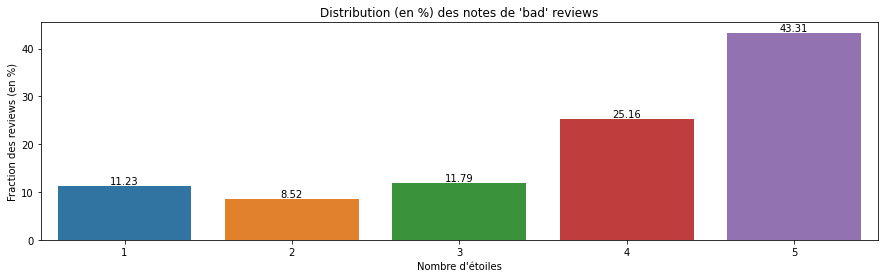

In [30]:
select = pd.DataFrame(data_clean.stars.value_counts()).reset_index()
select.sort_values(by='index', inplace=True)
select.set_index('index', inplace=True)

plot_bars(select.T, "Distribution (en %) des notes de 'bad' reviews", y_label="Fraction des reviews (en %)", x_label="Nombre d'étoiles", labels_rotation=0, show_percent=True)

>#### Nous constatons que la majorité des clients semblent satisfaits.
> Mais dans le cadre de notre projets nous voulons surtout identifier *les sujets qui préoccupent les personnes ayant laissé une mauvaise note*.<br>
> Nous allons donc travailler sur un échantillon de reviews dont les notes sont de 1 ou 2.

#### Binarisation du jeu de données

In [31]:
data_clean['is_low'] = data_clean.stars <= 2 # TRUE with 1,2 stars and FALSE with 3,4,5 stars
display(data_clean.head(2), data_clean.shape)

,stars,text,is_low
0,3,"If you decide to eat here, just be aware it is...",False
2,3,Family diner. Had the buffet. Eclectic assortm...,False


(681571, 3)

In [32]:
data_clean[data_clean.is_low].shape

(134575, 3)

>#### On a donc environ 216k "mauvaises" reviews à utiliser *(en aillant limité le nombre initial de reviews chargées à 1000k)*

#### Sélection au hasard des "mauvaises" reviews *(en conservant le ratio initial des notes)*

In [33]:
sample_size = 10000

In [34]:
# Select samples with the original dataset stars' ratio
data_bad_reviews = data_clean[data_clean.is_low == True].sample(sample_size, random_state=random_seed)[['stars', 'text']].reset_index(drop=True)
display(data_bad_reviews.head(2), data_bad_reviews.shape)

,stars,text
0,1,The crust was severely burned. The taste was s...
1,2,Eating outdoor was nice. Environment was nice....


(10000, 2)

#### Affichage de la distribution des scores dans le nouveau dataset

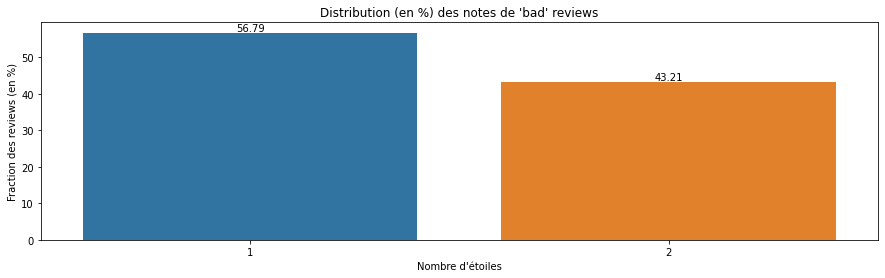

In [35]:
select = pd.DataFrame(data_bad_reviews.stars.value_counts()).reset_index()
select.sort_values(by='index', inplace=True)
select.set_index('index', inplace=True)

plot_bars(select.T, "Distribution (en %) des notes de 'bad' reviews", y_label="Fraction des reviews (en %)", x_label="Nombre d'étoiles", labels_rotation=0, show_percent=True)

---
---
# 3. Prétraitement des données <a class="anchor" id="pretraitement"></a> [⇪](#menu)

Nous allons utiliser pour préparer les données à l'analyse, une bibliothèque open-source appelée [spaCy](http://spacy.io), mais d'autres bibliothèques telles que [NLTK](https://www.nltk.org) peuvent également être utilisées.

Au cours du processus de Tokenisation, *spaCy* va ajouter plusieurs informations au document, que nous pourrons utiliser ultérieurement *(comme le type de mot, sont lemme, etc.)*

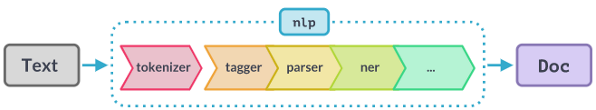

#### Visualisons le jeu de données avant la tokenisation

In [36]:
from wordcloud import WordCloud

In [37]:
from PIL import Image

In [38]:
def plot_wordcloud(text, from_frequency=False):
    alice_mask = np.array(Image.open("Documents/plate_shape.jpg"))
    
    # Create the wordcloud object (the size depends on the mask...)
    wordcloud = WordCloud(background_color="white", width=1000, height=700, margin=2, collocations=False, random_state=random_seed, mask=alice_mask)
    if from_frequency:
        wordcloud = wordcloud.generate_from_frequencies(text)
    else:
        wordcloud = wordcloud.generate(text)

    # Display the generated image:
    fig = plt.figure(figsize=(15, 10.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

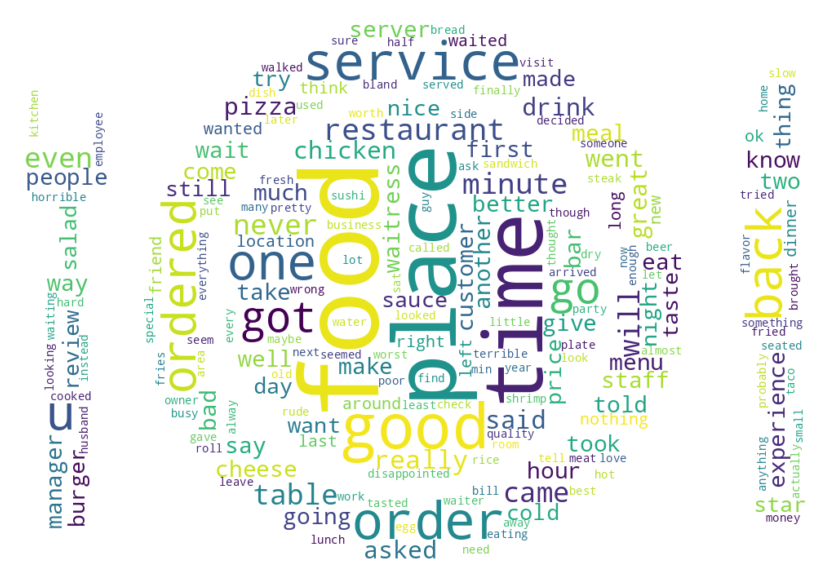

In [39]:
plot_wordcloud(" ".join([x for x in data_bad_reviews.text]))

## 3.1 Tokenization <a class="anchor" id="tokenize"></a> [⇪](#menu)
>#### Nous allons profiter de cette étape de tokenisation pour supprimer:
> - les majuscules,
> - ~~les espaces en début et fin de texte.~~
> - tout ce qui n'est pas détecté comme étant de l'anglais,
> - la ponctuation,
> - les stop-words,
> - les espaces,
> - les chiffres,
> - les ADVerbes.
>
>#### Par ailleurs on va utiliser les **lemmes** *(raçines contextualisées)* des mots pour rassembler ceux qui sont assez similaires.

In [40]:
!python -m spacy download en_core_web_sm -qq
#!python -m spacy download en_core_web_md -qq
nlp = spacy.load('en_core_web_sm')

2022-06-28 16:20:32.945802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 16:20:32.945851: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [41]:
nlp.add_pipe("language_detector")

In [42]:
def tokenize(text):

    # suppression des majuscules
    text = text.lower()

    # suppression des espaces au début et à la fin des textes
    text = text.strip()

    # tokenisation
    return nlp(text)

> pos_ tag ist
>
> - `ADJ`: adjective, e.g. big, old, green, incomprehensible, first
> - `ADP`: adposition, e.g. in, to, during
> - `ADV`: adverb, e.g. very, tomorrow, down, where, there
> - `AUX`: auxiliary, e.g. is, has (done), will (do), should (do)
> - `CONJ`: conjunction, e.g. and, or, but
> - `CCONJ`: coordinating conjunction, e.g. and, or, but
> - `DET`: determiner, e.g. a, an, the
> - `INTJ`: interjection, e.g. psst, ouch, bravo, hello
> - `NOUN`: noun, e.g. girl, cat, tree, air, beauty
> - `NUM`: numeral, e.g. 1, 2017, one, seventy-seven, IV, MMXIV
> - `PART`: particle, e.g. ’s, not,
> - `PRON`: pronoun, e.g I, you, he, she, myself, themselves, somebody
> - `PROPN`: proper noun, e.g. Mary, John, London, NATO, HBO
> - `PUNCT`: punctuation, e.g. ., (, ), ?
> - `SCONJ`: subordinating conjunction, e.g. if, while, that
> - `SYM`: symbol, e.g. $, %, §, ©, +, −, ×, ÷, =, :), 😝
> - `VERB`: verb, e.g. run, runs, running, eat, ate, eating
> - `X`: other, e.g. sfpksdpsxmsa
> - `SPACE`: space, e.g. 

In [43]:
display(data_bad_reviews.head(2), data_bad_reviews.shape)

,stars,text
0,1,The crust was severely burned. The taste was s...
1,2,Eating outdoor was nice. Environment was nice....


(10000, 2)

In [44]:
data_bad_reviews['spacy_doc'] = data_bad_reviews.text.apply(tokenize)

In [45]:
display(data_bad_reviews.head(2), data_bad_reviews.shape)

,stars,text,spacy_doc
0,1,The crust was severely burned. The taste was s...,"(the, crust, was, severely, burned, ., the, ta..."
1,2,Eating outdoor was nice. Environment was nice....,"(eating, outdoor, was, nice, ., environment, w..."


(10000, 3)

## 3.2 Filtrage des tokens <a class="anchor" id="filter"></a> [⇪](#menu)

In [46]:
def filter_tokens(doc, except_words = []):

    # suppression des majuscules
    # text = text_.lower()

    # suppression des espaces au début et à la fin des textes
    #text = text.strip()

    # tokenisation
    # doc = nlp(text)
    # spacy.displacy.render(doc, style='dep',jupyter=True)
    
    # suppression des stopwords, de la ponctuation, des espaces et des adverbes et de ce qui n'est pas en anglais
    tokens = [token for token in doc 
              if not token.is_stop 
              and doc._.language == 'en'
              and doc._.language_score > 0.7
              #and not token.is_punct
              #and not token.is_space 
              #and not token.is_digit 
              and token.is_alpha
              and token.pos_ not in ['ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SPACE', 'SYM'] 
              and token.lemma_ not in except_words
             ]
        
    return tokens

#### Regardons si il y a des textes dans d'autres langues ou dans de l'anglais approximatif

In [47]:
for doc in data_bad_reviews.spacy_doc:
    # is in english
    if doc._.language != 'en':
        print("NOT ENGLISH:\n", doc, "\n", "-"*50)
    elif doc._.language_score <= 0.7:
        print(f"GIBBERISH:{doc._.language_score}\n", doc, "\n", "-"*50)

NOT ENGLISH:
 não compro no mercado brasileiro com frequência, porém cada vez vejo menos variedade e menos empenho por parte dos funcionários quanto ao atendimento. alguns funcionários não são receptivos, não se colocam à disposição, e não falam inglês ou português. não sei quais são as condições de trabalho, mas como consumidora tenho menos interesse. 
 --------------------------------------------------
NOT ENGLISH:
 リノにはインド料理店が２店あります。この店は古くからあり、数年前に店舗の拡張するほど、美味しくにんきのある店"でした"。
残念ながら、個々のカレーの特徴がなく、香辛料の味がしないうえに全て同じような味になってしまいました。
香辛料の効いた美味しいカレーバッフェに行きたいのであれば、south lake tahoeまで足を伸ばすことをおすすめします。 
 --------------------------------------------------
GIBBERISH:0.5120385885238647
 on a friday night: t-shirt, athletic shorts, and sneakers ok; slacks, a button down, but sandals a no-no. 
 --------------------------------------------------
GIBBERISH:0.6891529560089111
 food very good...not too clean...disorganized...a dissapointment....but a very popular place....go figure....skip it 
 -----------

>#### On découvre:
> - plusieurs textes en espagnol ou en japonais/chinois
> - un casier judiciaire
> - des textes rédigés en plusieurs langues

#### Appliquons un filtre pour nettoyer ces tokens
- Suppression des langues étrangères *(ce qui n'est pas de l'Anglais)*
- Suppression des stop-words
- Suppression des mots qui ne sont pas composés de lettres de l'alphabet

In [48]:
data_bad_reviews['tokens'] = data_bad_reviews.spacy_doc.apply(filter_tokens)

## 3.3 Lemmatization des tokens <a class="anchor" id="lemmatize"></a> [⇪](#menu)

In [49]:
def lemmatize(doc):
    return [token.lemma_ for token in doc]

#### Lemmatisons les tokens

In [50]:
data_bad_reviews['lemmas'] = data_bad_reviews.tokens.apply(lemmatize)

In [51]:
display(data_bad_reviews.head(2), data_bad_reviews.shape)

,stars,text,spacy_doc,tokens,lemmas
0,1,The crust was severely burned. The taste was s...,"(the, crust, was, severely, burned, ., the, ta...","[crust, burned, taste, sub, hands, worst, pizza]","[crust, burn, taste, sub, hand, bad, pizza]"
1,2,Eating outdoor was nice. Environment was nice....,"(eating, outdoor, was, nice, ., environment, w...","[eating, outdoor, nice, environment, nice, ok,...","[eat, outdoor, nice, environment, nice, ok, bl..."


(10000, 5)

#### Visualisons le jeu de données après la tokenisation

In [52]:
def get_all_lemmas(data):
    all_lemmas = []
    for tokens in data:
        all_lemmas.extend(tokens)
    return all_lemmas

all_lemmas = get_all_lemmas(data_bad_reviews.lemmas)

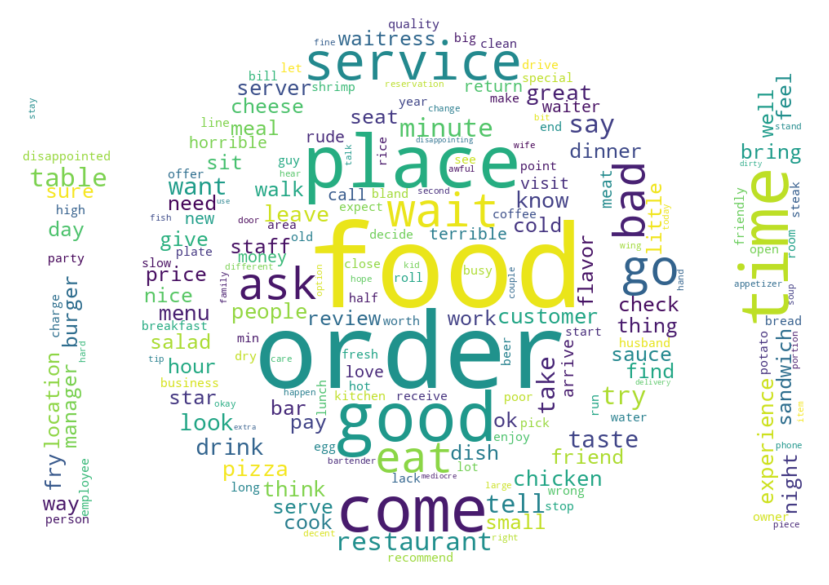

In [53]:
plot_wordcloud(" ".join(all_lemmas))

## 3.4 Suppression des mots les plus fréquents <a class="anchor" id="most_frequents"></a> [⇪](#menu)

In [54]:
lemmas_freq = Counter(all_lemmas)
common_lemmas = lemmas_freq.most_common(100)
print (common_lemmas)

[('food', 8681), ('order', 7760), ('place', 5598), ('good', 4812), ('time', 4655), ('come', 4458), ('service', 4163), ('go', 3627), ('get', 3285), ('wait', 3224), ('like', 3193), ('ask', 2892), ('bad', 2797), ('eat', 2797), ('restaurant', 2662), ('minute', 2583), ('say', 2533), ('table', 2502), ('tell', 2315), ('try', 2305), ('take', 2201), ('want', 2170), ('taste', 1989), ('look', 1918), ('drink', 1912), ('know', 1784), ('pizza', 1767), ('great', 1713), ('leave', 1702), ('experience', 1626), ('people', 1626), ('think', 1625), ('chicken', 1625), ('fry', 1601), ('customer', 1534), ('menu', 1533), ('server', 1528), ('sit', 1464), ('waitress', 1418), ('meal', 1408), ('staff', 1354), ('hour', 1345), ('give', 1341), ('bar', 1304), ('price', 1287), ('cheese', 1285), ('manager', 1275), ('well', 1267), ('thing', 1233), ('review', 1208), ('sauce', 1202), ('pay', 1200), ('serve', 1190), ('night', 1178), ('way', 1158), ('star', 1153), ('walk', 1139), ('need', 1111), ('salad', 1108), ('sandwich', 

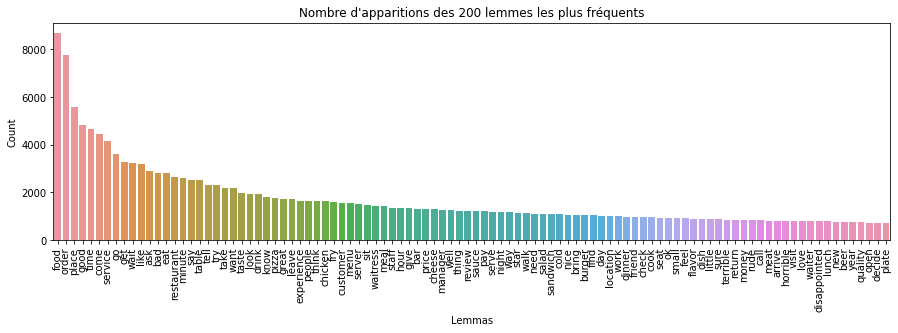

In [55]:
select = pd.DataFrame(common_lemmas[:200], columns=['lemmas','count'])
plot_bars(select, title="Nombre d'apparitions des 200 lemmes les plus fréquents", x='lemmas', y='count', show_values=False, y_label="Count", x_label="Lemmas")

>#### Les mots les plus fréquents sont des mots peu informatifs car présent dans la plupart des textes...
> Par exemple les lemmes `Food` ou `order` font plus de 6000 aparitions sur un jeu de données d'environ 10000 textes.

> On va les supprimer à la création du Dictionnaire

In [56]:
drop_lemmas = [x[0] for x in lemmas_freq.most_common(100)]
#drop_lemmas.extend(['come', 'go', 'tell', 'say', 'get', 'ask', 'want', 'try', 'look', 'take', 'find', 'let', 'guy', 'arrive', 'think'])

#### Visualisons le jeu de données après ce nettoyage plus complet

## 3.5 Création du Dictionnaire <a class="anchor" id="dict"></a> [⇪](#menu)

Pour les modèles que nous allons essayer, il nous faut un **Dictionnaire** et un **Corpus**.
- Le Dictionnaire permet d'associer un ID unique à chaque token.
- Le Corpus - Bag Of Word associe ID du dictionnaire à une fréquence.
- Le Corpus - TF-IDF associe ID chaque mot du dictionnaire à la fréquence d'apparition de ce terme, dans un document.

In [57]:
from gensim.corpora.dictionary import Dictionary

In [58]:
dictionary = Dictionary(data_bad_reviews['lemmas'])

In [59]:
print(str(dictionary.token2id)[:1000], "... }")

{'bad': 0, 'burn': 1, 'crust': 2, 'hand': 3, 'pizza': 4, 'sub': 5, 'taste': 6, 'bland': 7, 'devouring': 8, 'eat': 9, 'environment': 10, 'flavorful': 11, 'good': 12, 'mushy': 13, 'nice': 14, 'ok': 15, 'outdoor': 16, 'reason': 17, 'slimy': 18, 'sour': 19, 'think': 20, 'use': 21, 'wrong': 22, 'advance': 23, 'anniversary': 24, 'area': 25, 'bar': 26, 'bowling': 27, 'btw': 28, 'celebrate': 29, 'champagne': 30, 'complain': 31, 'drink': 32, 'food': 33, 'free': 34, 'lane': 35, 'lounge': 36, 'month': 37, 'move': 38, 'occasion': 39, 'private': 40, 'repair': 41, 'res': 42, 'ruin': 43, 'sit': 44, 'special': 45, 'stair': 46, 'surprise': 47, 'unsatisfied': 48, 'waitress': 49, 'wedding': 50, 'air': 51, 'frozen': 52, 'game': 53, 'greasy': 54, 'half': 55, 'horrible': 56, 'keep': 57, 'place': 58, 'thing': 59, 'ahole': 60, 'apply': 61, 'ask': 62, 'bc': 63, 'big': 64, 'bill': 65, 'blame': 66, 'bring': 67, 'bs': 68, 'charro': 69, 'cold': 70, 'come': 71, 'cut': 72, 'discount': 73, 'experience': 74, 'find': 7

In [60]:
len(dictionary)

13795

#### Supprimons les mots les plus fréquents et les moins fréquents
- On supprime les mots qui apparaissent dans moins de 5 documents
- On supprime les mots qui apparaissent dans plus de 50% des documents

In [61]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=None)

In [62]:
len(dictionary)

4294

#### Récupérons la Fréquence de chaque lemme pour afficher à nouveau le WordCloud

In [63]:
dico_df = pd.DataFrame(dictionary.items(), columns=['index', 'key']).set_index('index')

In [64]:
values = [[x[0], x[1]] for x in dictionary.cfs.items()]

In [65]:
count_df = pd.DataFrame(values, columns=['index','count']).set_index('index').sort_values('index')

In [66]:
TF = count_df.merge(dico_df, on='index', how='left').set_index('key')

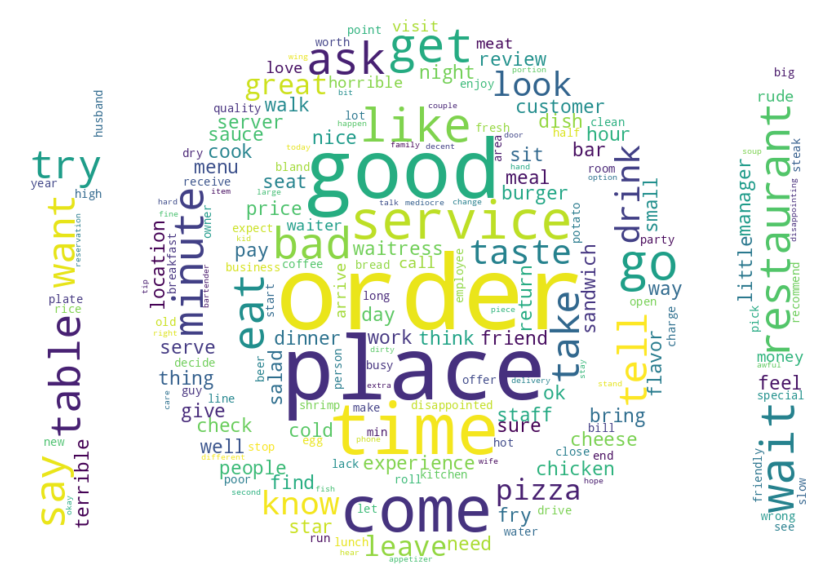

In [67]:
plot_wordcloud(TF.to_dict()['count'], from_frequency=True)

In [68]:
dictionary.most_common(10)

[('order', 7760),
 ('place', 5598),
 ('good', 4812),
 ('time', 4655),
 ('come', 4458),
 ('service', 4163),
 ('go', 3627),
 ('get', 3285),
 ('wait', 3224),
 ('like', 3193)]

## 3.6 Création du Corpus Bag-Of-Words <a class="anchor" id="corpus_bow"></a> [⇪](#menu)

Le Corpus - Bag Of Word associe ID du dictionnaire à une fréquence.

In [69]:
corpus_bow = [dictionary.doc2bow(doc) for doc in data_bad_reviews['lemmas']]

## 3.7 Création du Corpus TF-IDF <a class="anchor" id="corpus_tfidf"></a> [⇪](#menu)

Le Corpus - TF-IDF associe ID chaque mot du dictionnaire à la fréquence d'apparition de ce terme, dans un document.

#### Calculons les TF-IDF

In [70]:
from gensim.models import TfidfModel

In [71]:
tfidf = TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]

---
---
# 4. Topic Modelling avec LDA<a class="anchor" id="lda_topic_modelling"></a> [⇪](#menu)

## 4.1 Latent Dirichlet Allocation *(LDA)* <a class="anchor" id="lda"></a> [⇪](#menu)

C'est une méthode non-supervisée générative vraiment efficace qui se base sur les hypothèses suivantes :
- Chaque document du corpus est un ensemble de mots sans ordre (bag-of-words)
- Chaque document *m* aborde un certain nombre de thèmes dans différentes proportions qui lui sont propres *p(θm)*
- Chaque mot possède une distribution associée à chaque thème *p(ϕk)*. On peut ainsi représenter chaque thème par une probabilité sur chaque mot.
- *z_n* représente le thème du mot *w_n*

> ⚠️ "In fact, Blei (who developed LDA), points out in the introduction of the paper of 2003 (entitled "Latent Dirichlet Allocation") that LDA addresses the shortcomings of the TF-IDF model and leaves this approach behind. LSA is compeltely algebraic and generally (but not necessarily) uses a TF-IDF matrix, while LDA is a probabilistic model that tries to estimate probability distributions for topics in documents and words in topics. The weighting of TF-IDF is not necessary for this."
>
> ⚠️ Le modèle **TF-IDF peut améliorer les résultats d'un LDA** dans le cas d'un **nombre extrêmement important de documents**. Mais dans l'ensemble, le **Bag-Of-Words est plus approprié** pour le modèle LDA.

#### Regardons ce qui donne un modèle LDA sur 10 topics

In [72]:
from gensim.models import LdaMulticore, CoherenceModel

In [73]:
lda_model = LdaMulticore(corpus=corpus_bow, id2word=dictionary, iterations=50, num_topics=10, passes=10, random_state=random_seed)

In [74]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus_bow, dictionary)
pyLDAvis.display(lda_display)

>#### On voit assez clairement que le nombre de cluster n'est pas idéal... ils sont très proches les uns des autres, ils se chevauchent.

## 4.2 Recheche du nombre optimal de sujets <a class="anchor" id="lda_coherence"></a> [⇪](#menu)

Les algorithmes de topic modelling reposent sur les mathématiques et les statistiques, mais les sujets mathématiquement optimaux ne sont pas nécessairement "bons" d'un point de vue humain et peuvent être des sujets trompeurs et dénués de sens.

L'évaluation des sujets est donc habituellement complétée par des évaluations humaines telles que la lecture des mots les plus importants de chaque sujet et la visualisation des sujets liés à chaque document *(word-cloud utilisés plus haut)*. Malheureusement, cette tâche exige souvent des connaissances préalables sur le domaine du jeu de données et peut nécessiter l'avis de spécialistes. Et même si l'on dispose d'un tel spécialiste, une telle vérification peut prendre beaucoup de temps et s'avérer impraticable pour de très grands ensembles de données contenant des milliers de sujets.

#### Score de Cohérence

Il convient donc d'utiliser une métrique capable de vérifier **automatiquement** que les mots groupés ensemble ont bel et bien un thème commun. C'est ce que font les métriques de **mesure de cohérence** des sujets qui tentent de représenter la qualité de la perception humaine des sujets sous la forme d'un nombre unique en mesurant le degré de similarité sémantique entre les mots ayant obtenu un score élevé dans chaque thème.

Un point important des mesures de cohérence des sujets est qu'**elles dépendent non seulement du sujet lui-même mais aussi de l'ensemble de données utilisé comme référence**...

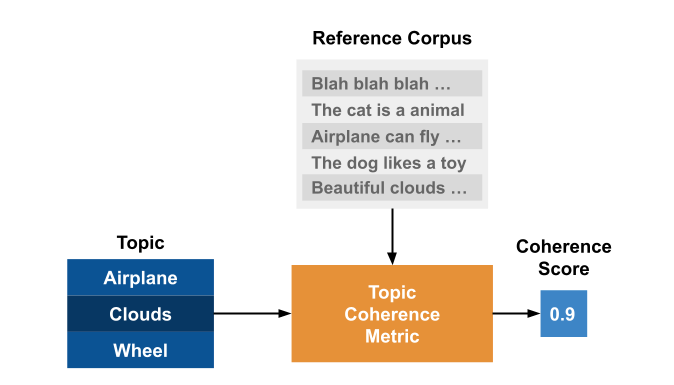

Il existe plusieurs modèles pour calculer un score de coéherence *(C_v, C_p, C_uci, C_umass, C_npmi, C_a, ...)*, mais nous allons utiliser le modèle C_umass car il est souvent recommandé *(mais aussi parcque c'est celui qui m'a donné les résultats les plus rapides lors de mes tests...)*.

#### C_umass
- la mesure de cohérence retournée par le modèle C_umass est négative,
- plus le score est grand et plus la mesure de cohérence indique que le sujet est compréhensible par les humains.


#### Calculons les courbes de cohérence avec le corpus TF-IDF

In [75]:
def plot_coherence(scores, max_topics):
    plt.figure(figsize=(10, 4))
    plt.plot(range(1,max_topics), scores)
    plt.gca().xaxis.grid(True)
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.xticks(range(0,max_topics))
    plt.show()

In [76]:
score = []
max_topics = 15
for i in tqdm(range(1,max_topics,1)):
    lda_model = LdaMulticore(corpus=corpus_tfidf, id2word=dictionary, iterations=10, num_topics=i, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=lda_model, corpus=corpus_tfidf, dictionary=dictionary, coherence='u_mass')
    score.append(cm.get_coherence())

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 8/14 [04:48<03:40, 36.68s/it]/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/ho

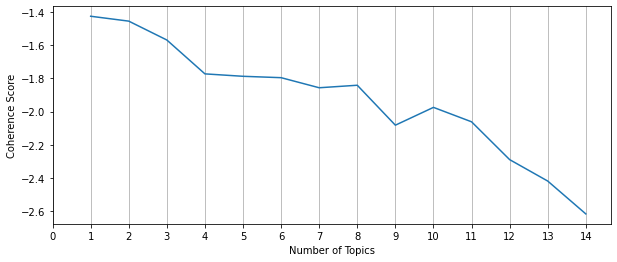

In [77]:
plot_coherence(score, max_topics)

#### Calculons les courbes de cohérence avec le corpus Bag-Of-Words

In [78]:
score = []
max_topics = 15
for i in tqdm(range(1,max_topics,1)):
    lda_model = LdaMulticore(corpus=corpus_bow, id2word=dictionary, iterations=10, num_topics=i, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=lda_model, corpus=corpus_bow, dictionary=dictionary, coherence='u_mass')
    score.append(cm.get_coherence())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [03:41<00:00, 15.84s/it]


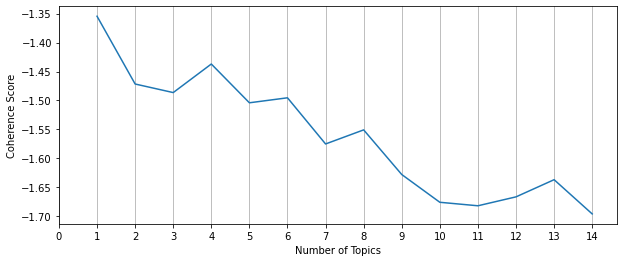

In [79]:
plot_coherence(score, max_topics)

#### ~~Calculons le score c_v~~ --> Trop long avec ce jeu de donnée

#### Conclusion
> En regardons l'évolution du score de cohérence avec le Corpus BoW (qui est plus dapté pour un LDA), on constate que le nombre idéal de sujets est de 1 ou 2... mais comme ça ne présente pas vraiment d'intérêt, nous allons partir sur 4 qui a un score intéressant également.

## 4.3 Logs des courbes de cohérences pour divers essais <a class="anchor" id="lda_coherence_logs"></a> [⇪](#menu)

### En retirant les 100 lemmes les plus fréquents

#### Avec le corpus TF-IDF
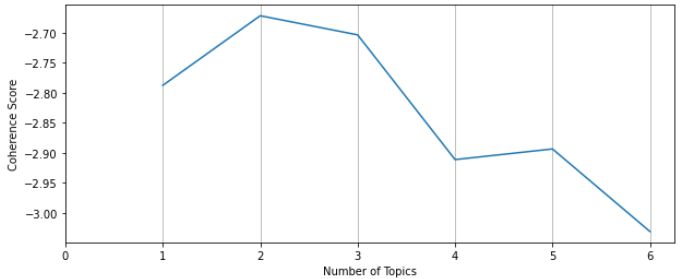

#### Avec le corpus Bag-Of-Words
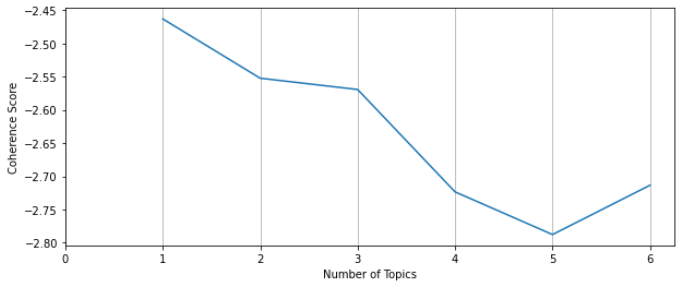

### En retirant les 50 lemmes les plus fréquents

#### Avec le corpus TF-IDF
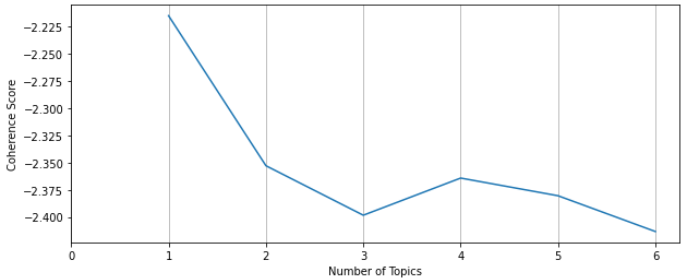

#### Avec le corpus Bag-Of-Words
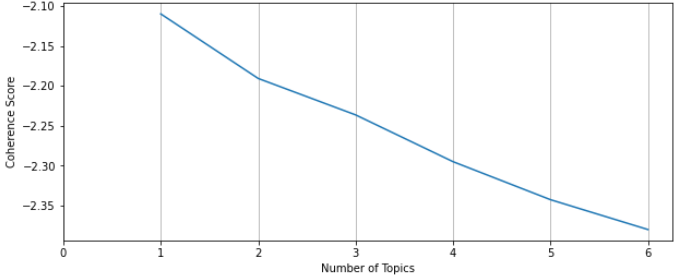

### En retirant les 5 lemmes les plus fréquents

#### Avec le corpus TF-IDF
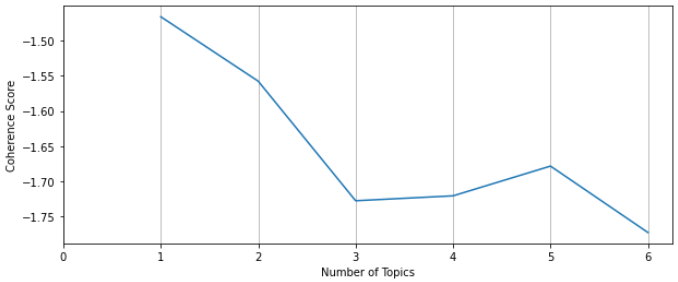

#### Avec le corpus Bag-Of-Words
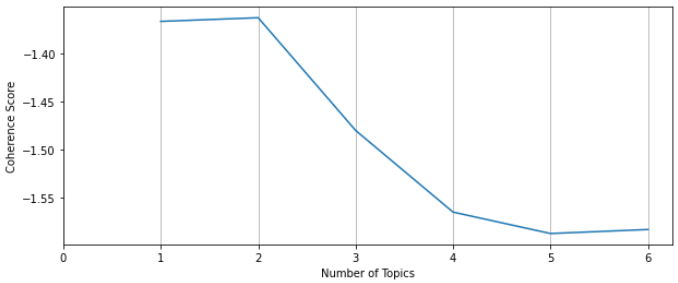

### Sans retirer les lemmes les plus fréquents (hors dictionary.filter_extremes)

#### Avec le corpus TF-IDF
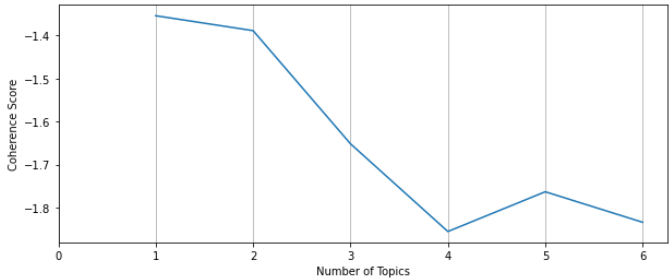

#### Avec le corpus Bag-Of-Words
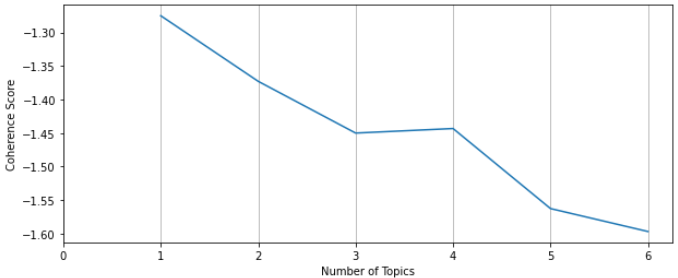

---
---
# 5. Topic Modelling avec NMF<a class="anchor" id="nmf_topic_modelling"></a> [⇪](#menu)

## 5.1 Negative Matrix Factorisation *(NMF)* <a class="anchor" id="nmf"></a> [⇪](#menu)

In [80]:
from gensim.models import Nmf

In [81]:
import warnings
warnings.filterwarnings("ignore", message="Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.")

In [82]:
# Train the model on the corpus.
nmf = Nmf(corpus_tfidf, num_topics=10)

## 5.2 Recheche du nombre optimal de sujets <a class="anchor" id="nmf_coherence"></a> [⇪](#menu)

#### Avec le corpus TF-IDF

In [83]:
score = []
max_topics = 15
for i in tqdm(range(1,max_topics,1)):
    nmf_model = Nmf(corpus=corpus_tfidf, num_topics=i, id2word=dictionary, passes=10, random_state=random_seed)
    #nmf_model = Nmf(corpus=corpus_tfidf, num_topics=i, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=nmf_model, corpus=corpus_tfidf, dictionary=dictionary, coherence='u_mass')
    score.append(cm.get_coherence())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [05:38<00:00, 24.15s/it]


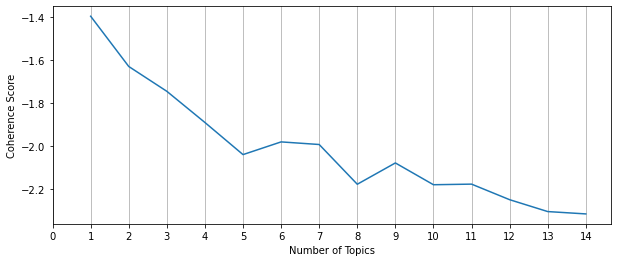

In [84]:
plot_coherence(score, max_topics)

#### Avec le corpus Bag-Of-Words

In [85]:
score = []
max_topics = 15
for i in tqdm(range(1,max_topics,1)):
    nmf_model = Nmf(corpus=corpus_bow, num_topics=i, id2word=dictionary, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=nmf_model, corpus=corpus_bow, dictionary=dictionary, coherence='u_mass')
    score.append(cm.get_coherence())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [01:54<00:00,  8.19s/it]


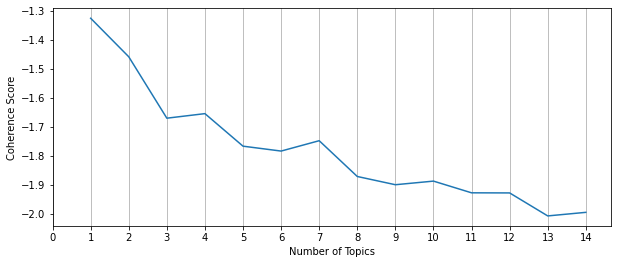

In [86]:
plot_coherence(score, max_topics)

## 5.3 Logs des courbes de cohérences pour divers essais <a class="anchor" id="nmf_coherence_logs"></a> [⇪](#menu)

### En retirant les 100 lemmes les plus fréquents

#### Avec le corpus TF-IDF
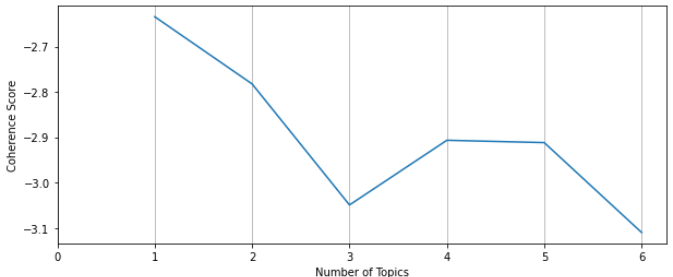

#### Avec le corpus Bag-Of-Words
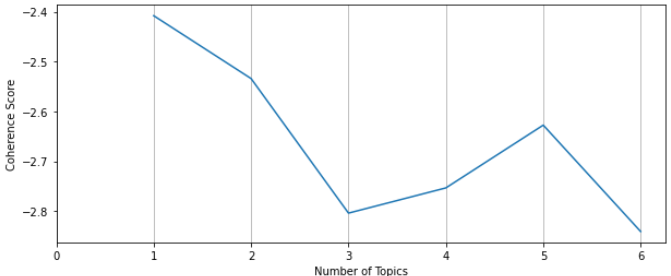

### Sans retirer les lemmes les plus fréquents (hors dictionary.filter_extremes)

#### Avec le corpus TF-IDF
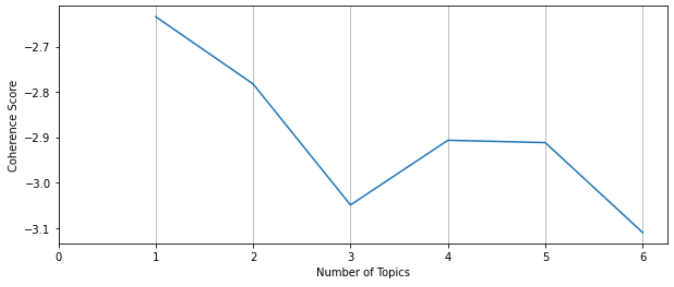

#### Avec le corpus Bag-Of-Words
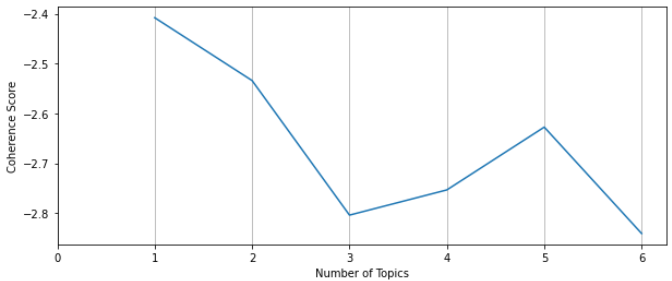

---
---
# 6. Modèle final<a class="anchor" id="final_model"></a> [⇪](#menu)

## 6.1 Entrainement & interprétation du meilleur modèle LDA <a class="anchor" id="final_model_lda"></a> [⇪](#menu)

Nous avons vu avec les courbes de cohérences que le meilleur choix pour le LDA semble être de chercher **4 sujets** en utilisant le **corpus Bag-Of-Words**.

### Entrainons donc le modèle avec le nombre de sujets optimal

In [87]:
num_topics = 4
lda_model = LdaMulticore(corpus=corpus_bow, id2word=dictionary, iterations=100, num_topics=num_topics, passes=100, random_state=random_seed)

### Affichons les lemme utilisés pour définir les sujets et leur poids

In [100]:
lda_model.print_topics(-1)

[(0,
  '0.020*"good" + 0.019*"order" + 0.014*"place" + 0.014*"taste" + 0.013*"like" + 0.013*"chicken" + 0.012*"fry" + 0.010*"eat" + 0.009*"sauce" + 0.009*"get"'),
 (1,
  '0.032*"order" + 0.017*"time" + 0.015*"place" + 0.014*"say" + 0.013*"customer" + 0.013*"go" + 0.012*"tell" + 0.012*"service" + 0.011*"ask" + 0.009*"come"'),
 (2,
  '0.028*"pizza" + 0.022*"place" + 0.013*"good" + 0.011*"like" + 0.008*"price" + 0.008*"breakfast" + 0.008*"room" + 0.008*"coffee" + 0.008*"go" + 0.007*"look"'),
 (3,
  '0.023*"table" + 0.023*"come" + 0.022*"wait" + 0.020*"service" + 0.019*"order" + 0.017*"time" + 0.017*"minute" + 0.015*"drink" + 0.015*"ask" + 0.013*"server"')]

### Cherchons les textes qui collent le plus aux sujets pour nous aider à les interpréter

In [103]:
max_values = {}
max_index = {}
for i in range(len(corpus_bow)):
    row = dict(lda_model[corpus_bow][i])
    
    for j in range(num_topics):
        if row.get(j, 0) > max_values.get(j, 0):
            max_values[j] = row.get(j, 0)
            max_index[j] = i
            
    #if i > 10000:
    #    break
        
print(max_values)
print(max_index)

{0: 0.99551475, 1: 0.9944851, 2: 0.9932719}
{0: 7026, 1: 7562, 2: 4726}


In [90]:
explore_id = 138  # (0) 439 (1) 1252 (2) 1934 (3) x
display(lda_model[corpus_bow][explore_id])
display(data_bad_reviews['text'][explore_id])

[(0, 0.028952505), (1, 0.4433708), (2, 0.0301674), (3, 0.49750933)]

"Worst casino in America don't bother very few table games and unlike las Vegas you pay for your drinks"

### Visualisons les sujets avec pyLDAvis

Le graphique `pyLDAvis` ci-dessus représente les sujets sous forme de cercles, réduits en dimmensionalité à l'aide d'une PCA.

Dans l'idéal, les cercles ne doivent pas se chevaucher et même maximiser la distance entre eux car les sujets les plus proches les uns des autres sont aussi les sujets les plus liés (donc les sujets potentiellement redondants). Lorsque l'on clique sur un cercle, les différents lemmes sont affichés à droite avec leurs fréquences dans le corpus en bleu et leurs fréquences estimées dans le sujet sélectionné en rouge.

In [91]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus_bow, dictionary)
pyLDAvis.display(lda_display)

### Interprétons les sujets

In [92]:
lda_model.print_topics(-1)

[(0,
  '0.020*"good" + 0.019*"order" + 0.014*"place" + 0.014*"taste" + 0.013*"like" + 0.013*"chicken" + 0.012*"fry" + 0.010*"eat" + 0.009*"sauce" + 0.009*"get"'),
 (1,
  '0.032*"order" + 0.017*"time" + 0.015*"place" + 0.014*"say" + 0.013*"customer" + 0.013*"go" + 0.012*"tell" + 0.012*"service" + 0.011*"ask" + 0.009*"come"'),
 (2,
  '0.028*"pizza" + 0.022*"place" + 0.013*"good" + 0.011*"like" + 0.008*"price" + 0.008*"breakfast" + 0.008*"room" + 0.008*"coffee" + 0.008*"go" + 0.007*"look"'),
 (3,
  '0.023*"table" + 0.023*"come" + 0.022*"wait" + 0.020*"service" + 0.019*"order" + 0.017*"time" + 0.017*"minute" + 0.015*"drink" + 0.015*"ask" + 0.013*"server"')]

>#### On peut supposer que :
> - le `sujet 0` concerne `la qualité du service`.
> - le `sujet 1` concerne `le ratio qualité / prix ou qualité / attente`.
> - le `sujet 2` concerne `le temps d'attente`.
> - le `sujet 3` concerne `le goût / la qualité de la nourriture`.

## 6.2 Entrainement & interprétation du meilleur modèle NMF <a class="anchor" id="final_model_nmf"></a> [⇪](#menu)

Nous avons vu avec les courbes de cohérences que le meilleur choix pour le LDA semble être de chercher **4 sujets** en utilisant le **corpus Bag-Of-Words**.

### Entrainons donc le modèle avec le nombre de sujets optimal

In [93]:
num_topics = 3
nmf_model = Nmf(corpus=corpus_bow, num_topics=num_topics, id2word=dictionary, passes=10, random_state=random_seed)

### Affichons les lemme utilisés pour définir les sujets et leur poids

In [94]:
nmf_model.print_topics(-1)

[(0,
  '0.037*"wait" + 0.030*"minute" + 0.030*"come" + 0.024*"ask" + 0.023*"time" + 0.022*"table" + 0.020*"say" + 0.020*"order" + 0.018*"tell" + 0.015*"go"'),
 (1,
  '0.083*"order" + 0.020*"pizza" + 0.011*"like" + 0.011*"place" + 0.011*"eat" + 0.010*"get" + 0.010*"fry" + 0.010*"cheese" + 0.010*"good" + 0.010*"chicken"'),
 (2,
  '0.024*"place" + 0.020*"good" + 0.013*"service" + 0.012*"like" + 0.009*"restaurant" + 0.009*"come" + 0.009*"time" + 0.008*"go" + 0.008*"bad" + 0.007*"try"')]

### Cherchons les textes qui collent le plus aux sujets pour nous aider à les interpréter

In [95]:
max_values = {}
max_index = {}
for i in range(len(corpus_bow)):
    row = dict(nmf_model[corpus_bow][i])
    
    for j in range(num_topics):
        if row.get(j, 0) > max_values.get(j, 0):
            max_values[j] = row.get(j, 0)
            max_index[j] = i
            
    if i > 2000:
        break
        
print(max_values)
print(max_index)

{1: 1.0, 2: 1.0, 0: 1.0}
{1: 27, 2: 3, 0: 8}


In [96]:
explore_id = 138  # (0) (1) (2) (3) 
display(nmf_model[corpus_bow][explore_id])
display(data_bad_reviews['text'][explore_id])

[(0, 0.7142105720338446), (2, 0.28578942796615536)]

"Worst casino in America don't bother very few table games and unlike las Vegas you pay for your drinks"

### Visualisons les sujets avec pyLDAvis

Le graphique `pyLDAvis` ci-dessus représente les sujets sous forme de cercles, réduits en dimmensionalité à l'aide d'une PCA.

Dans l'idéal, les cercles ne doivent pas se chevaucher et même maximiser la distance entre eux car les sujets les plus proches les uns des autres sont aussi les sujets les plus liés (donc les sujets potentiellement redondants). Lorsque l'on clique sur un cercle, les différents lemmes sont affichés à droite avec leurs fréquences dans le corpus en bleu et leurs fréquences estimées dans le sujet sélectionné en rouge.

In [97]:
mnf_display = pyLDAvis.gensim_models.prepare(nmf_model, corpus_bow, dictionary)
pyLDAvis.display(mnf_display)

AttributeError: 'Nmf' object has no attribute 'inference'

### Interprétons les sujets

In [ ]:
lda_model.print_topics(-1)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative us

>#### On peut supposer que :
> - le `sujet 0` concerne `la qualité du service`.
> - le `sujet 1` concerne `le ratio qualité / prix ou qualité / attente`.
> - le `sujet 2` concerne `le temps d'attente`.
> - le `sujet 3` concerne `le goût / la qualité de la nourriture`.

## 6.3 Export du modèle sélectionné <a class="anchor" id="final_model_export"></a> [⇪](#menu)